## <ins>SETUP</ins>

In [1]:
import pandas as pd
import requests

from igraph import Graph, plot

In [2]:
cols = [
    "type", "sflow_agent_address", "input_port", "output_port", "src_mac", \
    "dst_mac", "ethernet_type", "in_vlan", "out_vlan", "src_ip", \
    "dst_ip", "ip_protocol", "ip_tos", "ip_ttl", "src_port", \
    "dst_port", "tcp_flags", "packet_size", "ip_size", "sampling_rate", \
]
df = pd.read_csv("./actual_data.csv", usecols=range(20), header=None, names=cols)

df.head()

,type,sflow_agent_address,input_port,output_port,src_mac,dst_mac,ethernet_type,in_vlan,out_vlan,src_ip,dst_ip,ip_protocol,ip_tos,ip_ttl,src_port,dst_port,tcp_flags,packet_size,ip_size,sampling_rate
0,FLOW,aa.aa.aa.aa,137,200,d404ff55fd4d,80711fc76001,0x0800,919.0,280,130.246.176.22,140.115.32.81,6,0x00,50,51216.0,23505,0x10,1518,1500,2048
1,FLOW,aa.aa.aa.aa,129,193,609c9f851b00,0031466b23cf,0x0800,11.0,919,155.69.160.32,64.233.188.128,6,0x00,56,23159.0,80,0x10,74,52,2048
2,FLOW,aa.aa.aa.aa,137,200,d404ff55fd4d,80711fc76001,0x0800,919.0,280,130.246.176.53,140.115.32.83,6,0x00,50,50041.0,20739,0x10,1518,1500,2048
3,FLOW,aa.aa.aa.aa,129,135,609c9f851b00,002688cd5fc7,0x0800,11.0,919,155.69.160.32,54.169.174.79,17,0x00,120,54241.0,26510,0x10,116,94,2048
4,FLOW,aa.aa.aa.aa,130,199,00239cd087c1,544b8cf9a7df,0x0800,919.0,600,137.132.228.15,193.62.192.8,6,0x00,56,53923.0,34262,0x10,70,52,2048


In [3]:
def get_org(ip):
    return requests.get(f"http://ip-api.com/json/{ip}").json()["org"]

## <ins>EXERCISE 4A: TOP TALKERS AND LISTENERS</ins>

### <ins>TOP TALKERS</ins>

In [4]:
talkers = df.loc[:, ["src_ip"]] \
    .value_counts() \
    .nlargest(5) \
    .reset_index() \
    .rename({0: "count"}, axis=1) 

talkers.loc[:, "src_org"] = talkers.loc[:, "src_ip"].apply(get_org)

talkers = talkers.loc[:, ["src_ip", "src_org", "count"]]

talkers

,src_ip,src_org,count
0,193.62.192.8,European Bioinformatics Institute,3041
1,155.69.160.32,Nanyang Technological University,2975
2,130.14.250.11,National Library of Medicine,2604
3,14.139.196.58,Indian Institute of Technology,2452
4,140.112.8.139,,2056


### <ins>TOP LISTENERS</ins>

In [5]:
listeners = df.loc[:, ["dst_ip"]] \
    .value_counts() \
    .nlargest(5) \
    .reset_index() \
    .rename({0: "count"}, axis=1) 

listeners.loc[:, "dst_org"] = listeners.loc[:, "dst_ip"] \
    .apply(get_org)

listeners = listeners.loc[:, ["dst_ip", "dst_org", "count"]]

listeners

,dst_ip,dst_org,count
0,103.37.198.100,A*STAR,3841
1,137.132.228.15,National University of Singapore,3715
2,202.21.159.244,Rpnet,2446
3,192.101.107.153,"Battelle Memorial Institute, Pacific Northwest...",2368
4,103.21.126.2,Indian Institute of Technology Bombay,2056


## <ins>EXERCISE 4B: TRANSPORT PROTOCOL</ins>

In [6]:
ip_type = df.loc[:, ["ip_protocol"]] \
    .value_counts()[[6, 17]] \
    .reset_index() \
    .rename({0: "count"}, axis=1)

ip_type.loc[:, "percentage"] = 100*ip_type.loc[:, "count"] / df.shape[0]

ip_type

,ip_protocol,count,percentage
0,6,56064,80.818798
1,17,9462,13.639902


## <ins>EXERCISE 4C: APPLICATIONS PROTOCOL</ins>

In [7]:
df[["dst_port"]] \
    .value_counts() \
    .nlargest(5) \
    .reset_index() \
    .rename({0: "count"}, axis=1)

,dst_port,count
0,443,13423
1,80,2647
2,52866,2068
3,45512,1356
4,56152,1341


## <ins>EXERCISE 4D: TRAFFIC</ins>

In [8]:
size_recorded = df["ip_size"].sum() / (1024**2)
total_size = size_recorded * 2048

print(f"Total traffic: {total_size:.3f} MB")

Total traffic: 126519.184 MB


## <ins>EXERCISE 4E: ADDITIONAL ANALYSIS </ins>

### <ins>TOP 5 COMMUNICATION PAIRS</ins>

In [9]:
top_comm_pairs = df.groupby(["src_ip", "dst_ip"]) \
    .size() \
    .sort_values(ascending=False) \
    .nlargest(5) \
    .reset_index() \
    .rename({0: "count"}, axis=1)

top_comm_pairs.loc[:, "src_org"] = top_comm_pairs.loc[:, "src_ip"].apply(get_org)
top_comm_pairs.loc[:, "dst_org"] = top_comm_pairs.loc[:, "dst_ip"].apply(get_org)

top_comm_pairs = top_comm_pairs.loc[:, ["src_ip", "src_org", "dst_ip", "dst_org", "count"]]
top_comm_pairs.to_csv("top_comm_pairs.csv")

top_comm_pairs

,src_ip,src_org,dst_ip,dst_org,count
0,193.62.192.8,European Bioinformatics Institute,137.132.228.15,National University of Singapore,3041
1,130.14.250.11,National Library of Medicine,103.37.198.100,A*STAR,2599
2,14.139.196.58,Indian Institute of Technology,192.101.107.153,"Battelle Memorial Institute, Pacific Northwest...",2368
3,140.112.8.139,,103.21.126.2,Indian Institute of Technology Bombay,2056
4,137.132.228.15,National University of Singapore,193.62.192.8,European Bioinformatics Institute,1910


### <ins>GRAPHICAL VISUALISATION OF TOP 80 COMMUNICATING PAIRS</ins>

In [10]:
comm_pairs = df.groupby(["src_ip", "dst_ip"]) \
    .size() \
    .nlargest(80)
                       
comm_pairs.head()

src_ip          dst_ip         
193.62.192.8    137.132.228.15     3041
130.14.250.11   103.37.198.100     2599
14.139.196.58   192.101.107.153    2368
140.112.8.139   103.21.126.2       2056
137.132.228.15  193.62.192.8       1910
dtype: int64

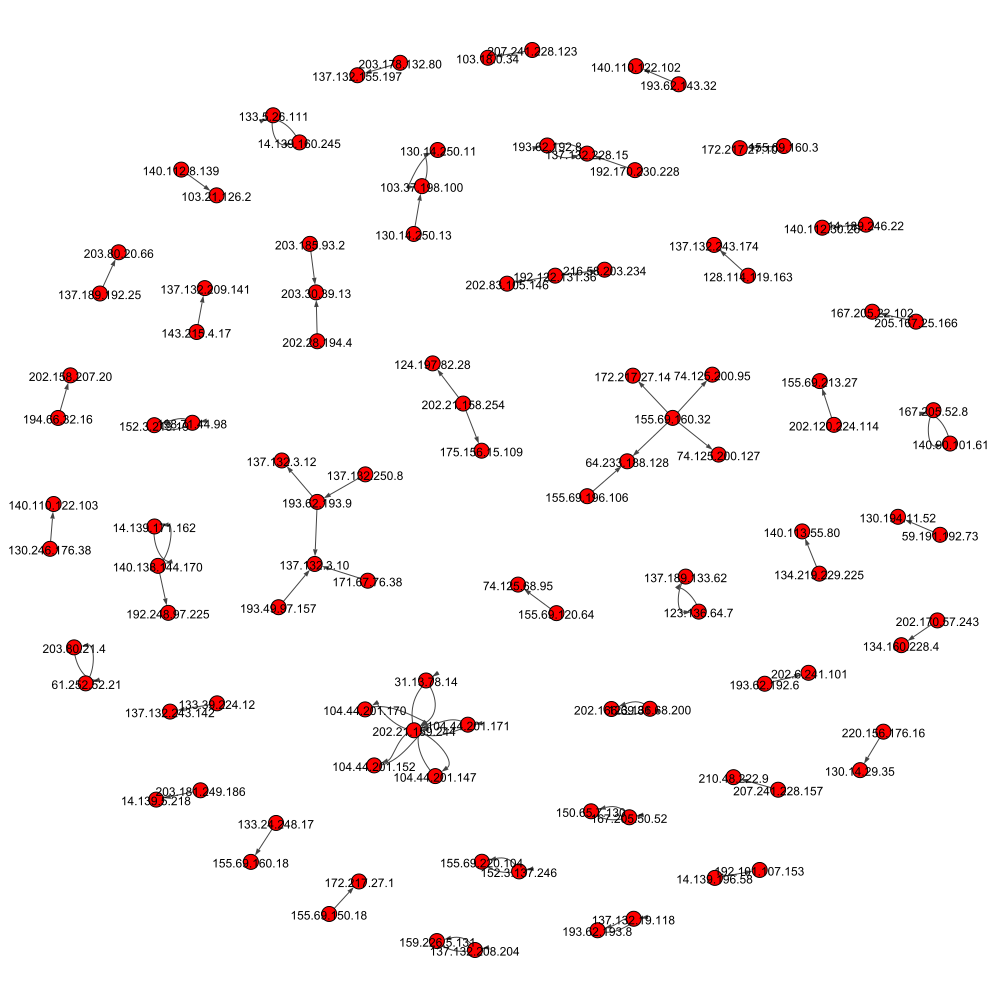

In [16]:
edges = [tuple(edge) for edge in comm_pairs.index]
graph = Graph.TupleList(edges, directed=True, weights=False)

graph.vs["size"] = 15
graph.vs["label_size"] = 12
graph.vs["label"] = graph.vs["name"]
graph.es["arrow_size"] = 0.5

plot(graph, "network_vis.png", margin=50, bbox=(1000, 1000))